In [1]:
# I use Colab to code, so I also use Google Drive to load img!

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Image Processing')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Colors separation and reconstruction

## (a) Use an existing library to separate the three channels of your RGB image and show each of them separately.

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

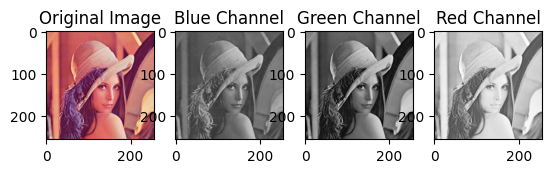

In [3]:
# Load Lena.png
image = cv2.imread('Lena.png')

# Split the image into RGB channels using cv2.split()
b, g, r = cv2.split(image)
plt.subplot(141), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(142), plt.imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB)), plt.title('Blue Channel')
plt.subplot(143), plt.imshow(cv2.cvtColor(g, cv2.COLOR_BGR2RGB)), plt.title('Green Channel')
plt.subplot(144), plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB)), plt.title('Red Channel')
plt.show()

## (b) Write your own algorithm to separate an RGB image into the three channels of the HSL color space (H, S, L).

In [4]:
def rgb_to_hsl(r, g, b):
    # The R,G,B values are divided by 255 to change the range from 0..255 to 0..1:
    R = r / 255.0
    G = g / 255.0
    B = b / 255.0

    Cmax = max(R, G, B)
    Cmin = min(R, G, B)
    delta = Cmax - Cmin  # Δ

    # Hue calculation:
    L = (Cmax + Cmin) / 2.0

    # Saturation calculation:
    # because delta is float, we can not use "=="
    if abs(delta) <= 0.0001:
        S = 0
    else:
        S = delta / (1 - abs(2 * L - 1))

    # Lightness calculation:
    if abs(delta) <= 0.0001:
        H = 0
    elif abs(Cmax - R) <= 0.0001:
        H = 60 * (((G - B) / delta) % 6)
    elif abs(Cmax - G) <= 0.0001:
        H = 60 * (((B - R) / delta) + 2)
    elif abs(Cmax - B) <= 0.0001:
        H = 60 * (((R - G) / delta) + 4)

    return H, S, L

In [5]:
image = cv2.imread('Lena.png')

# store the hsl
hsl_image = np.zeros_like(image, dtype=np.float32)

# apply rgb_to_hsl on every pixel
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        r, g, b = image[i, j]
        h, s, l = rgb_to_hsl(r, g, b)
        hsl_image[i, j] = [h, s, l]

np.save('Lena_hsl.npy', hsl_image)
cv2.imwrite('Lena_hsl.png', hsl_image)

True

## (c) Write your own algorithm to reconstruct an RGB image from the H, S, L channels.

In [6]:
def hsl_to_rgb(h, s, l):
    C = (1 - abs(2 * l - 1)) * s
    X = C * (1 - abs((h / 60) % 2 - 1))
    m = l - C / 2

    if 0 <= h < 60:
        R, G, B = C, X, 0
    elif 60 <= h < 120:
        R, G, B = X, C, 0
    elif 120 <= h < 180:
        R, G, B = 0, C, X
    elif 180 <= h < 240:
        R, G, B = 0, X, C
    elif 240 <= h < 300:
        R, G, B = X, 0, C
    elif 300 <= h < 360:
        R, G, B = C, 0, X
    # when h may have a wrong value
    else:
        R, G, B = 0, 0, 0

    R = int((R + m) * 255)
    G = int((G + m) * 255)
    B = int((B + m) * 255)

    return R, G, B

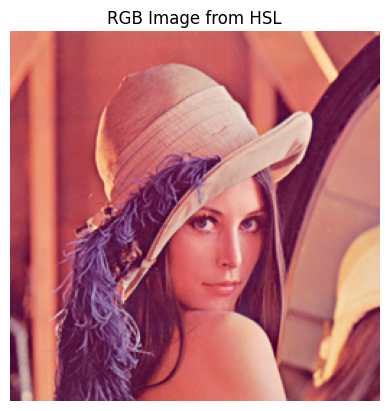

In [7]:
# store RGB image
hsl_image = np.load('Lena_hsl.npy')

rgb_image = np.zeros_like(hsl_image, dtype=np.uint8)

# Apply hsl_to_rgb on every pixel
for i in range(hsl_image.shape[0]):
    for j in range(hsl_image.shape[1]):
        h, s, l = hsl_image[i, j]
        r, g, b = hsl_to_rgb(h, s, l)
        rgb_image[i, j] = [r, g, b]

# Save the result as 'Lena_HSL2RGB.png'
cv2.imwrite('Lena_HSL2RGB.png', rgb_image)

plt_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
plt.imshow(plt_image)
plt.title("RGB Image from HSL")
plt.axis('off')
plt.show()

# 2. Greyscale Histogram Equalization

## (a) Write your own histogram equalization algorithm based on the method presented in the lecture.

In [8]:
# due to digital images are all discrete case

def histogram_equalization(img):

    # print(len(img))
    # print(len(img[0]))

    # calculate histogram
    histogram = [0] * 256
    for pixel_value in img.flatten():
        histogram[pixel_value] += 1

    # Computing the cumulative histogram as the ppt says:
    cumul = [0] * len(histogram)
    cumul[0] = histogram[0]
    for i in range(1, len(histogram)):
        cumul[i] = cumul[i-1] + histogram[i]

    # find min pixel which not equal to 0
    cumul = np.array(cumul)
    cumul_min = np.min(cumul[cumul > 0])
    # cumul[-1] - cumul_min means the "size"
    quant = (cumul - cumul_min) * 255 / (cumul[-1] - cumul_min)
    quant = np.round(quant).astype('uint8')

    # search the table and change the pixel
    img_equalized = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_equalized[i, j] = quant[img[i, j]]

    return quant, img_equalized

## (b) Apply your algorithm on the greyscale images provided on ILIAS.

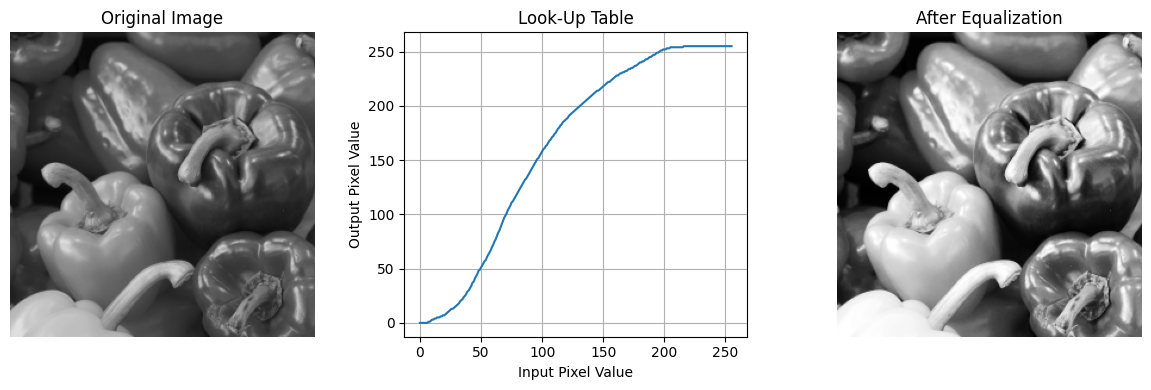

True

In [9]:
# read and convert it to grayscale (although it is gray)
img = cv2.imread('Peppers.png', cv2.IMREAD_GRAYSCALE)

quant, img_equalized = histogram_equalization(img)

plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Look-Up Table
plt.subplot(1, 3, 2)
plt.plot(quant)
plt.title('Look-Up Table')
plt.xlabel('Input Pixel Value')
plt.ylabel('Output Pixel Value')
plt.grid(True)

# After Equalization
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_equalized, cv2.COLOR_BGR2RGB))
plt.title('After Equalization')
plt.axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite('Peppers_Equalized.png', img_equalized)

# 3. Color Histogram Equalization

## (a) Firstly, apply your histogram equalization algorithm on the R, G, and B channels and reconstruct your image.

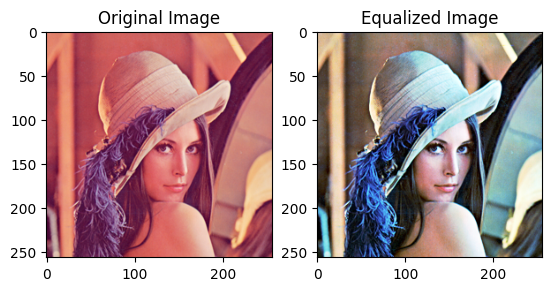

In [10]:
image = cv2.imread('Lena.png')

b, g, r = cv2.split(image)

# apply on each channel
_, b_equalized = histogram_equalization(b)
_, g_equalized = histogram_equalization(g)
_, r_equalized = histogram_equalization(r)

equalized_image = cv2.merge([b_equalized, g_equalized, r_equalized])

cv2.imwrite('Equalized_Lena.png', equalized_image)

plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)), plt.title('Equalized Image')
plt.show()

# the result is bad, I almost think I was wrong but I check all the function which are correct.
# so this maybe the right result: more blue than before

## (b) Secondly, apply the histogram equalization on the L channel of your HSL image and reconstruct your image with the new L channel and the original H and S channels. Convert the result on an RGB image.

In [11]:
def histogram_equalization_float(img):
    # Scale floating point values to [0, 255]
    scaled_img = (img * 255).astype(np.uint8)

    # Apply histogram equalization
    _, img_equalized = histogram_equalization(scaled_img)

    # Scale back to [0, 1]
    img_equalized_float = img_equalized.astype(np.float32) / 255.0

    return _, img_equalized_float

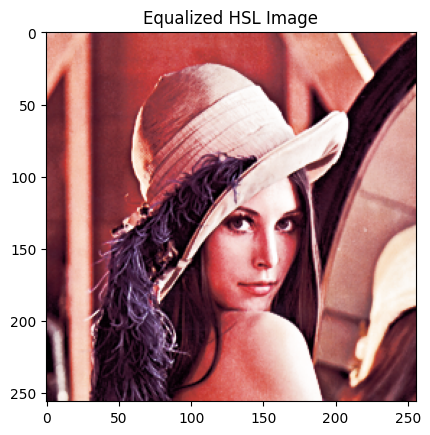

True

In [14]:
hsl_image = np.load('Lena_hsl.npy')

# apply histogram equalization on the L channel
_, L_equalized = histogram_equalization_float(hsl_image[:,:,2])

hsl_image_equalized = np.copy(hsl_image)
hsl_image_equalized[:,:,2] = L_equalized

# Convert the HSL image back to RGB
rgb_image = np.zeros_like(hsl_image_equalized, dtype=np.uint8)
for i in range(hsl_image.shape[0]):
    for j in range(hsl_image.shape[1]):
        h, s, l = hsl_image_equalized[i, j]
        r, g, b = hsl_to_rgb(h, s, l)
        rgb_image[i, j] = [r, g, b]

plt.subplot(111), plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)), plt.title('Equalized HSL Image')
plt.show()

cv2.imwrite('Equalized_HSL_Lena.png', rgb_image)

## (c) Visually compare the result of the two images after equalizing the histograms (RGB and HSL). What can you observe?

About Color:
If I equalize each channel of the RGB image, it will lead to colors appearing shifted or unnatural. Just like the "Blue Lena"; However, apply on HSL image with it L, the colors are better preserved because the hue and saturation remain unchanged.

About Brightness and Contrast:
Equalizing each channel of the RGB image will let some channel be contrast, but some will not; But Equalizing HSL image only focus on lightness and darkness rather than color, so it maybe perform better than applying on RGB image.